In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import sys
import gc
import os
import tensorflow as tf
from random import randint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold, datasets
from IPython.display import clear_output
from tsnecuda import TSNE


In [2]:
os.environ["QT_API"] = "pyqt5"
print(os.environ.get('QT_API'))

pyqt5


In [3]:
#import tsnecuda
#tsnecuda.test()

In [4]:
%matplotlib qt

In [5]:
#test tesnsorflow
print("tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
# Returns whether TensorFlow was built with CUDA (GPU) support.
print("tf.test.is_built_with_cuda = ",tf.test.is_built_with_cuda())
# Returns whether TensorFlow can access a GPU. (deprecated)
print("tf.test.is_gpu_available = ",tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))


tensorflow version:  2.1.0
Num GPUs Available:  1
Num CPUs Available:  1
tf.test.is_built_with_cuda =  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tf.test.is_gpu_available =  True


(480, 640, 3)


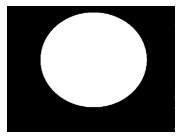

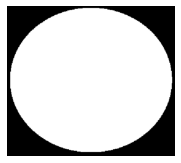

In [6]:
# read mask
%matplotlib inline
mask = np.array(cv2.imread('mask.png'))/255
mask[mask>0] = 1
print(mask.shape)
plt.figure(figsize=(3,3))
plt.imshow(mask,plt.cm.gray)
plt.axis("off");plt.show()

plt.figure(figsize=(3,3))
plt.imshow(mask[20:-85,120:-100],plt.cm.gray)
plt.axis("off");plt.show()

## check mask's white is 1
# temp = mask
# temp[temp==1] = 0
# plt.imshow(mask,plt.cm.gray)
# plt.axis("off");plt.show()

# read file for `white` picture

In [7]:
sort_name = {'k_30.png':0, 'k_40.png':1, '_100.png':2, 'LED1.png':3, 'LED2.png':4, 'LED3.png':5, 'LED4.png':6, 'LED5.png':7, 'LED6.png':8}
def sorted_file_name(file_name, sort_name):
    file_num = len(file_name)
    for i in range(file_num):
        temp = file_name[i*9:i*9+9]
        for string in temp:
            # print(string)
            # print(file_name[i*9+sort_name[string[-8:]]])
            file_name[i*9+sort_name[string[-8:]]] = string
    # print('\n'.join(file_name))


In [8]:
def read_white_file():
    print("reading data of white...")

    file_path='/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/*'
    file_name =sorted(glob.glob(file_path))
    sorted_file_name(file_name, sort_name)
    # print(file_name)
    print('\n'.join(file_name))
    file_num = len(file_name)

    white_data = np.zeros((file_num,375,420,3),dtype=np.uint8)

    for i in range(file_num):
        white_data[i] = (cv2.imread(file_name[i]) * mask )[20:-85,120:-100]

    print("white_data.shape = ",white_data.shape)
    ## plot image for white data
    # plt.figure(figsize=(10,5))
    # for i in range(file_num):
    #     plt.subplot(3,3,i+1)
    #     plt.axis("off")
    #     plt.title(file_name[i])
    #     plt.imshow(cv2.cvtColor(data[i], cv2.COLOR_BGR2RGB))
    # plt.show()

    print("reading data of white sucessful\n")
    return white_data


white_data = read_white_file()


reading data of white...
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085242_dark_30.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085241_dark_40.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085242_dark_100.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085243_LED1.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085243_LED2.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085244_LED3.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085244_LED4.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085245_LED5.png
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/white/20191122_085245_LED6.png
white_data.shape =  (9, 375, 420, 3)
reading data of white sucessful



# read file for `data` picture

In [9]:

def read_data_file():
    print("reading data....")

    ## read file path
    ## file path 1030 1104 1108 1118 112
    file_path='/home/shawn/DATA/Special_topic/Pleurotus_eryngii/*'
    folder_name = sorted(glob.glob(file_path))[:5]
    print('\n'.join(folder_name))
    print()
    file_name=[]
    for folder_name_c in folder_name:
        count = 0
        file_path = sorted(glob.glob(folder_name_c+"/*"))
        sorted_file_name(file_path, sort_name)
        # print('\n'.join(file_path))

        for fname in file_path:
            file_name.append(fname)
            count+=1
            if(count==9*1):
                pass
                # break
    data_Gnum = len(file_name)//9

    print("file_name number: ",len(file_name))
    print("data all Group number: ",len(file_name)//9)
    print("data_Gnum = ", data_Gnum)

    ## [data_Gnum][NumOfPicture][picture(480*640*wave)]
    data_black = np.zeros((data_Gnum,375,420,9),dtype=np.uint8)
    data       = np.zeros((data_Gnum,375,420,18),dtype=np.uint8)
    print("data_black.shpae = ",data_black.shape)
    print("data.shpae = ",data.shape)
    collected = gc.collect()
    print("Garbage collector: collected %d objects." % (collected))

    print("processing group")
    for group in range(data_Gnum):
        print("{}/{}".format(group+1,data_Gnum),end="\t")

        for black in range(3):
            img = cv2.imread(file_name[group*9+black]) * mask
            data_black[group][:,:,black*3:black*3+3] = img[20:-85,120:-100]

        for LED in range(6):
            img = cv2.imread(file_name[group*9+3+LED]) * mask
            data[group][:,:,LED*3:LED*3+3] = img[20:-85,120:-100]

    gc.collect()
    print("\nreading data sucessful\n")
    return data, data_black, data_Gnum

#=========================================================
data, data_black, data_Gnum = read_data_file()
print("data.type = ",type(data[0][0][0][0]))
print("data max = ", np.amax(data))
print("data max = ", np.amin(data))



reading data....
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/1030
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/1104
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/1108
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/1118
/home/shawn/DATA/Special_topic/Pleurotus_eryngii/1122

file_name number:  1296
data all Group number:  144
data_Gnum =  144
data_black.shpae =  (144, 375, 420, 9)
data.shpae =  (144, 375, 420, 18)
Garbage collector: collected 4362 objects.
processing group
1/144	2/144	3/144	4/144	

5/144	6/144	7/144	8/144	9/144	

10/144	11/144	12/144	13/144	14/144	

15/144	16/144	17/144	18/144	19/144	

20/144	21/144	22/144	23/144	24/144	

25/144	26/144	27/144	28/144	29/144	

30/144	31/144	32/144	33/144	34/144	

35/144	36/144	37/144	38/144	39/144	

40/144	41/144	42/144	43/144	44/144	

45/144	46/144	47/144	48/144	49/144	

50/144	51/144	52/144	53/144	54/144	

55/144	56/144	57/144	58/144	59/144	

60/144	61/144	62/144	63/144	64/144	

65/144	66/144	67/144	68/144	69/144	

70/144	71/144	72/144	73/144	74/144	

75/144	76/144	77/144	78/144	79/144	

80/144	81/144	82/144	83/144	84/144	

85/144	86/144	87/144	88/144	89/144	

90/144	91/144	92/144	93/144	94/144	

95/144	96/144	97/144	98/144	99/144	

100/144	101/144	102/144	103/144	104/144	

105/144	106/144	107/144	108/144	109/144	

110/144	111/144	112/144	113/144	114/144	

115/144	116/144	117/144	118/144	119/144	

120/144	121/144	122/144	123/144	124/144	

125/144	126/144	127/144	128/144	129/144	

130/144	131/144	132/144	133/144	134/144	

135/144	136/144	137/144	138/144	139/144	

140/144	141/144	142/144	143/144	144/144	


reading data sucessful

data.type =  <class 'numpy.uint8'>


data max =  255


data max =  0


white_data.shape =  (9, 4, 4, 3)
data.shape =  (144, 4, 4, 18)
data_black.shape =  (144, 4, 4, 9)


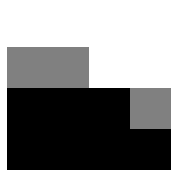

In [10]:
# Extract all part of the data (8x8)
size = 4
size_d2 = size/2
size_d2 = int(size_d2)
white_data = white_data[:,188-size_d2:188+size_d2, 210-size_d2:210+size_d2]
data = data[:,188-size_d2:188+size_d2, 210-size_d2:210+size_d2]
data_black = data_black[:,188-size_d2:188+size_d2, 210-size_d2:210+size_d2]

print("white_data.shape = ",white_data.shape)
print("data.shape = ",data.shape)
print("data_black.shape = ",data_black.shape)

plt.figure(figsize=(3,3))
plt.imshow(data[0][:, :, 0],plt.cm.gray)
plt.axis("off");plt.show()

In [11]:
# solve div0 question

def div0(a,b):
    b[b==0] = -1
    c = a/b
    c[c<0] = 0
    return c

def print_info(img):
    print("max =",np.amax(img))
    print("min =",np.amin(img))
    print("mean=",np.mean(img))

a = np.array([1.,0.,0.], dtype='float')
b = np.array([0.,1.,0.], dtype='float')
c = div0(a,b)
print(div0(a,b))

[ 0.  0. -0.]


# calculate reflectivity

In [12]:
## initialization
# [data_Gnum][NumOfPicture(LED)][picture(480*640*3)]
data = data.astype('float')
white_data = white_data.astype('float')
reflectivity = np.zeros_like(data, dtype='float')
print("reflectivity.shape=", reflectivity.shape)
print()

dark_30 = white_data[0]
dark_40 = white_data[1]
dark_100= white_data[2]
# print("dark_100.shape=",dark_100.shape)

LED1_white = white_data[3]
LED2_white = white_data[4]
LED3_white = white_data[5]
LED4_white = white_data[6]
LED5_white = white_data[7]
LED6_white = white_data[8]
# print("LED6_white.shape=",LED6_whdef array_divide(a,b):

print(type(dark_30[0][0][0]))


reflectivity.shape= (144, 4, 4, 18)

<class 'numpy.float64'>


In [13]:
# deal reflectivity
for Gnum in range(data_Gnum):
    shape = white_data.shape
    LED = np.zeros(white_data.shape,dtype=np.float)
    LED = LED[:6]
    for i in range(6):
        LED[i] = data[Gnum][:,:,i*3:i*3+3]

    reflectivity[Gnum][:,:,0:3]   = div0((LED[0]-dark_40) , (LED1_white-dark_40))
    reflectivity[Gnum][:,:,3:6]   = div0((LED[1]-dark_30) , (LED2_white-dark_30))
    reflectivity[Gnum][:,:,6:9]   = div0((LED[2]-dark_30) , (LED3_white-dark_30))
    reflectivity[Gnum][:,:,9:12]  = div0((LED[3]-dark_30) , (LED4_white-dark_30))
    reflectivity[Gnum][:,:,12:15] = div0((LED[4]-dark_30) , (LED5_white-dark_30))
    reflectivity[Gnum][:,:,15:]   = div0((LED[5]-dark_100), (LED6_white-dark_100))
    gc.collect()

    print("{}/{}\t".format(Gnum+1, data_Gnum),end="")

reflectivity[reflectivity<0] = 0
reflectivity[reflectivity>1] = 1
print("\nprocess sucessful\n")


1/144	2/144	3/144	4/144	5/144	6/144	7/144	8/144	

9/144	10/144	11/144	12/144	13/144	14/144	15/144	16/144	17/144	18/144	

19/144	20/144	21/144	22/144	23/144	

24/144	25/144	26/144	27/144	28/144	29/144	30/144	31/144	32/144	33/144	34/144	

35/144	36/144	37/144	38/144	39/144	40/144	41/144	42/144	

43/144	44/144	45/144	46/144	47/144	48/144	49/144	50/144	51/144	52/144	53/144	54/144	

55/144	56/144	57/144	58/144	59/144	60/144	

61/144	62/144	63/144	64/144	65/144	66/144	67/144	

68/144	69/144	70/144	71/144	72/144	73/144	74/144	75/144	

76/144	77/144	78/144	79/144	80/144	81/144	82/144	83/144	84/144	

85/144	86/144	87/144	88/144	89/144	90/144	91/144	92/144	93/144	94/144	

95/144	96/144	97/144	98/144	99/144	100/144	101/144	102/144	103/144	

104/144	105/144	106/144	107/144	108/144	109/144	110/144	111/144	

112/144	113/144	114/144	115/144	116/144	117/144	118/144	119/144	120/144	121/144	122/144	123/144	

124/144	125/144	126/144	127/144	128/144	129/144	130/144	131/144	132/144	

133/144	134/144	135/144	136/144	137/144	138/144	

139/144	140/144	141/144	142/144	143/144	

144/144	
process sucessful



In [14]:
del LED
del white_data, LED1_white, LED2_white, LED3_white, LED4_white, LED5_white, LED6_white
del dark_100, dark_30, dark_40
del data, data_black
%whos

Variable           Type        Data/Info
----------------------------------------
Gnum               int         143
PCA                ABCMeta     <class 'sklearn.decomposition._pca.PCA'>
StandardScaler     type        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TSNE               type        <class 'tsnecuda.TSNE.TSNE'>
a                  ndarray     3: 3 elems, type `float64`, 24 bytes
animation          module      <module 'matplotlib.anima<...>matplotlib/animation.py'>
b                  ndarray     3: 3 elems, type `float64`, 24 bytes
c                  ndarray     3: 3 elems, type `float64`, 24 bytes
clear_output       function    <function clear_output at 0x7f79b2089e60>
cv2                module      <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
data_Gnum          int         144
datasets           module      <module 'sklearn.datasets<...>rn/datasets/__init__.py'>
div0               function    <function div0 at 0x7f7912066d40>
gc                 module 

 group 0 ==================================


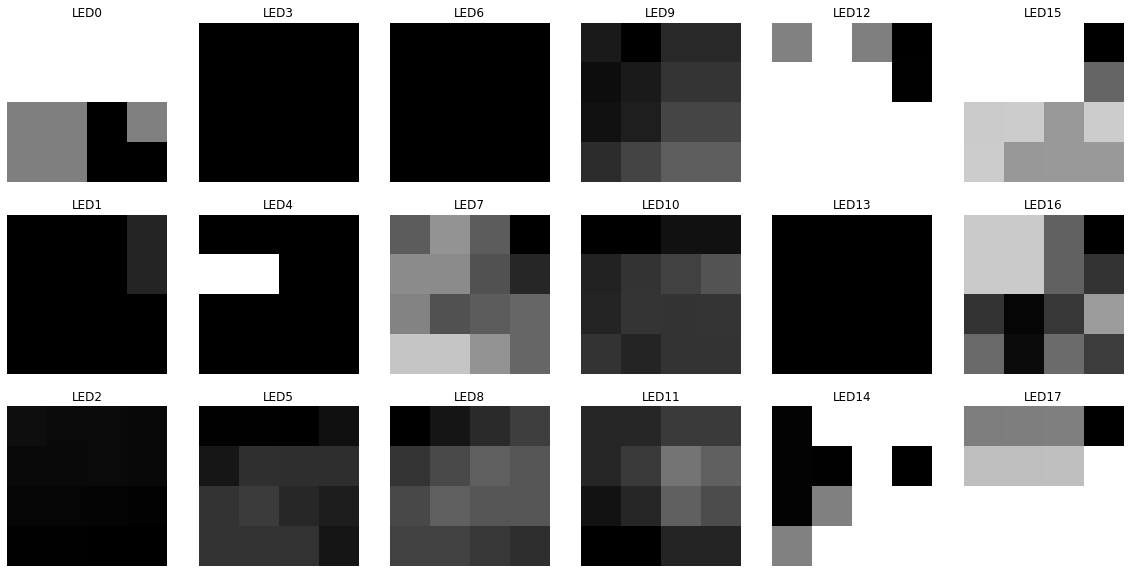

In [15]:
def set_figure_size():
    plt.figure(figsize=(20,10))

# [data_Gnum][NumOfPicture(LED)][picture(480*640*3)]
for Gnum in range(data_Gnum):
    print(" group {} ==================================".format(Gnum))

    set_figure_size()
    figure_index = 0
    for col in range(6):
        for row in range(3):
            plt.subplot(3,6,col+1+row*6)
            plt.axis("off")
            plt.title("LED{}".format(figure_index))

            # plt.imshow(data[Gnum][:,:,figure_index], plt.cm.gray, vmax=1.0)
            plt.imshow(reflectivity[Gnum][:,:,figure_index], plt.cm.gray, vmax=1.0)
            figure_index += 1
    plt.show()
    break


# del data witch we don't want

In [ ]:
reflectivity_process = reflectivity
del reflectivity
reflectivity_process = np.delete(reflectivity_process,9,3)
reflectivity_process = np.delete(reflectivity_process,6,3)
reflectivity_process = np.delete(reflectivity_process,4,3)
reflectivity_process = np.delete(reflectivity_process,3,3)
reflectivity_process = np.delete(reflectivity_process,1,3)

def set_figure_size():
    plt.figure(figsize=(20,10))

# [data_Gnum][NumOfPicture(LED)][picture(480*640*3)]
for Gnum in range(data_Gnum):
    if(Gnum==1):
        break

    print(" group {} ==================================".format(Gnum))
    set_figure_size()
    figure_index = 0
    for col in range(6):
        for row in range(3):
            if(figure_index==13):
                break
            plt.subplot(3,6,col+1+row*6)
            plt.axis("off")
            plt.title("LED{}".format(figure_index))
            plt.imshow(reflectivity_process[Gnum][:,:,figure_index], plt.cm.gray, vmax=1.0)
            figure_index += 1
    plt.show()


# let data to be a spectral curve

In [16]:
# let curve to (144,18)
print(reflectivity.shape)
curve = reflectivity
print(curve.shape)
curve = curve.transpose(0,3,1,2)
print(curve.shape)
(group,band,x,y) = curve.shape
curve = curve.reshape(group,band,x*y)
# curve = curve.transpose(1,0,2)
print(curve.shape)
curve = np.mean(curve,axis=2)
print(curve.shape)


(144, 4, 4, 18)
(144, 4, 4, 18)
(144, 18, 4, 4)
(144, 18, 16)
(144, 18)


In [17]:
# z-scroce
print("total is {}".format(curve.shape[0]))
for data_n in range(curve.shape[0]):
    m = np.mean(curve[data_n])
    std = np.std(curve[data_n])
    curve[data_n] = (curve[data_n]-m)/std
    if data_n%1000 is 0:
        print(data_n, end=' ')
print("\nsucessful")

total is 144
0 
sucessful


In [18]:
curve[curve== np.nan] = 0
curve[curve== np.inf] = 0
curve[curve==-np.inf] = 0
if np.nan in curve:
    print("12")
else:
    print("121")
print(np.max(curve))
print(np.min(curve))


121
0.9913102105558205
-2.022453884876918


In [24]:
%matplotlib qt
data_n = curve.shape[0]
print(data_n)
colormap = plt.cm.rainbow(np.linspace(0, 1, data_n))
plt.ion()
plt.figure(figsize = (15,7))
plt.xlim(0,19)
plt.xticks(np.arange(0, 19, 1))

for data_G in range(0, data_n, 6):
    plt.plot(np.linspace(1,18,18),curve[data_G],color=colormap[data_G])
    plt.pause(0.05)

plt.show()



144


# t-SNE

In [ ]:
n_components = 2
perplexity = 20
early_exaggeration = 15
learning_rate = 10
n_iter = 1000
n_iter_without_progress = 300
min_grad_norm = 1e-07
metric = 'euclidean'
init = 'pca'
verbose = 1
random_state = None
method = 'barnes_hut'
angle = 0.5
n_jobs = None

range_ = 1
start = 400

## ========================== Recursive processing tsne ==========================
# data_norm_n = np.zeros((range_,data_n,2))
# print(data_norm_n.shape)

# print("Process...")
# for perplexity in range(start,start+range_):
#     print("{}/{}".format(perplexity-start+1,range_),end='\t')
#     tsne = manifold.TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration,\
#                         learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=n_iter_without_progress,\
#                         min_grad_norm=min_grad_norm, metric=metric, init=init, verbose=False,\
#                         random_state=random_state, method=method, angle= angle, n_jobs=n_jobs)
#     tSNE_data = tsne.fit_transform(curve[:data_n])
#     file_name = "t-SNE_144_n{}_per{}_lr{}_iter{}".format(n_components,perplexity,learning_rate,n_iter)

#     # print("\nOrg data dimension is {}\n\
#     # Embedded data dimension is {}".format(reflectivity_p_s.shape, tSNE_data.shape))

#     data_min, data_max = tSNE_data.min(0), tSNE_data.max(0)
#     data_norm = (tSNE_data - data_min) / (data_max - data_min)
#     # print(data_norm.shape)
#     data_norm_n[perplexity-start] = data_norm
# print("\nProcess sucessful")

## ========================== processing tsne onces ==========================
# tsne = manifold.TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration,\
#                     learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=n_iter_without_progress,\
#                     min_grad_norm=min_grad_norm, metric=metric, init=init, verbose=False,\
#                     random_state=random_state, method=method, angle= angle, n_jobs=n_jobs)
# tSNE_data = tsne.fit_transform(curve)
# file_name = "t-SNE_144_n{}_per{}_lr{}_iter{}".format(n_components,perplexity,learning_rate,n_iter)

# print("\nOrg data dimension is {}\n\
# Embedded data dimension is {}".format(reflectivity_p_s.shape, tSNE_data.shape))

## ========================== use tsnecuda onces ==========================
tSNE_data = TSNE(n_components=2, perplexity=30000, learning_rate=250, n_iter=2000).fit_transform(curve)

## ========================== normalize tSNE_norm ==========================
data_min, data_max = tSNE_data.min(0), tSNE_data.max(0)
data_norm = (tSNE_data - data_min) / (data_max - data_min)
# print(data_norm.shape)
print("\nProcess sucessful")

colormap = plt.cm.rainbow(np.linspace(0, 1, data_Gnum))
plt.ion()
for num in range(range_):
    for i in range(data_n):
        plt.text(data_norm_n[num,i, 0], data_norm_n[num,i, 1], str(i), color=colormap[i],
                fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]); plt.yticks([]); plt.title('perplexity = {} range={}~{}'.format(start+num,start,start+range_))
    plt.pause(1)
    plt.clf()


In [ ]:
print(data_norm.shape)
print(data_norm)

In [ ]:
step = data_norm.shape[0]//10000
# 2d with text
%matplotlib qt
colormap = plt.cm.rainbow(np.linspace(0, 1, data_norm.shape[0]))
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
for i in range(0, data_norm.shape[0]//2, step):
# for i in range(5):
    plt.text(data_norm[i, 0], data_norm[i, 1], str(i), color=colormap[i],
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([]); plt.yticks([]);
# plt.savefig('d:/Special_topic/program/t-SNE_result/{}.png'.format(file_name))
# plt.show()

In [ ]:
# 2d with text
# %matplotlib qt
# colormap = plt.cm.rainbow(np.linspace(0, 1, data_norm.shape[0]))
# plt.figure(figsize = (10,10))
plt.subplot(1,2,2)

for i in range(data_norm.shape[0]//2, data_norm.shape[0], step):
    plt.text(data_norm[i, 0], data_norm[i, 1], str(i), color=colormap[i],
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([]); plt.yticks([]);
# plt.savefig('d:/Special_topic/program/t-SNE_result/{}.png'.format(file_name))
plt.show()


# 3D
%matplotlib qt
colormap = plt.cm.rainbow(np.linspace(0, 1, data_norm.shape[0]))
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection='3d')
for i in range(data_norm.shape[0]):
    ax.text(data_norm[i,0], data_norm[i,1], data_norm[i,2],str(i), color=colormap[i])
    # ax.scatter(data_norm[i,0], data_norm[i,1], data_norm[i,2],str(i), cmap=colormap[i])

plt.savefig('d:/Special_topic/program/t-SNE_result/{}.png'.format(file_name))
plt.show()


In [ ]:
x = [[1,2,3],[4,5,6]]
x = np.array(x)
print(np.sum(x))

In [ ]:
import os; print(os.environ.get('QT_API'))